# Praktikum 4, Monte Carlo

## Importance sampling

Apply importance sampling to the autoconversion integral that you have studied previously.
The function to integrate, $f(\chi,N_c)$, is a function of $\chi$, which is related to cloud water mixing ratio, and $N_c$, which is the cloud droplet number.
The PDF, $P(\chi,N_c)$, is a normal-lognormal;
it is given by Eqns. (31) and (32) in Larson and Griffin (2013), except that you should include $N_{cn}$ in the denominator of the prefactor.

In [ ]:
def f(chi, N_c, alpha=2.47, beta=-1.79):
    """Autoconversion.

    Autoconversion is the process by which small cloud droplets grow in size
    and become rain drops. Therefore, if there is more cloud water or larger
    drops, rain forms more easily.

    Args:
        chi (float): Cloud water mixing ratio.
        alpha (float): Often take to 2.47
        beta (float): Often take to -1.79
        N_c (float): Number of Cloud droplets.
    """
    from numpy import nan_to_num
    from numpy import power
    from numpy import heaviside
    return nan_to_num(heaviside(chi, 1) * np.power(chi, alpha) * power(N_c, beta))

1. Exponential tilting.
As the importance function $q$, choose a normal-lognormal PDF, like
$P(\chi,N_c)$, but with more favorable values of the means $\chi$ and $N_c$.
Experiment with pairs of mean values until you find a pair that produces reduced noise.

In [1]:
import numpy as np
from scipy.stats import norm


def a_chi_n_c(chi, n_c, alpha=2.47, beta=-1.79):
    return np.nan_to_num(np.heaviside(chi, 1) * np.power(chi, alpha) * np.power(n_c, beta))


def draw_from_uniform_dist(n: int):
    return np.random.uniform(size=n)


def transform_to_standard_normal(points):
    return norm.ppf(points)


def create_chi_n_c(num_points: int):
    chi = np.array(transform_to_standard_normal(draw_from_uniform_dist(num_points)))
    n_c = np.array(transform_to_standard_normal(draw_from_uniform_dist(num_points)))
    return np.array([chi, n_c])


def transform_to_correlated_by_cholesky(sigma_x, sigma_y, r_12, Y, my):
    L = np.array([[sigma_x, 0], [sigma_y * r_12, sigma_y * np.sqrt(1 - (r_12 ** 2))]])
    return L.dot(Y) + my


def lognormal_correlated_bivariate_dist(correlated_bivariate_dist):
    return np.array([correlated_bivariate_dist[0].copy(), np.exp(correlated_bivariate_dist[1])])


def generate_X(num_points=100, sigma_x=1, sigma_y=1, r_12=0.99, mu=0):
    return lognormal_correlated_bivariate_dist(
        transform_to_correlated_by_cholesky(sigma_x, sigma_y, r_12, create_chi_n_c(num_points), mu))

[[-0.21719191 -0.28771792 -0.11675898 ... -0.23008609  0.07664026
   0.85591001]
 [ 0.8142817   0.97478417  0.8737655  ...  0.88963009  1.18980109
   2.42544397]]


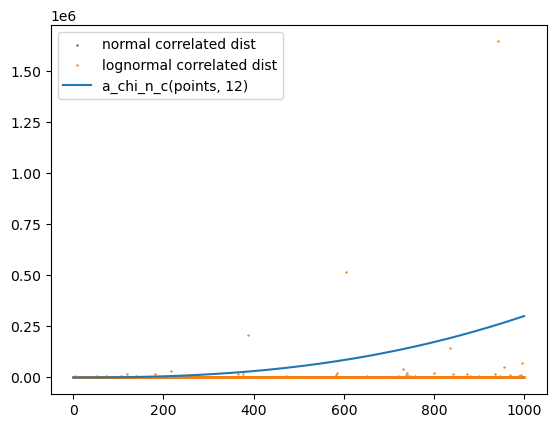

In [19]:
from matplotlib import pyplot as plt

X = generate_X(num_points=1000, sigma_x=1, sigma_y=5, r_12=0.99, mu=0)

points_x = np.linspace(start=0, stop=len(X[0]), num=len(X[0]))
plt.plot()
plt.scatter(points_x, X[0], s=0.5, label='normal correlated dist')
plt.scatter(points_x, X[1], s=0.5, label='lognormal correlated dist')
plt.plot(points_x, a_chi_n_c(chi=points_x, n_c=12), label = 'a_chi_n_c(points, 12)')
plt.legend()
plt.show()

In [44]:
from scipy.special import gamma, pbdv


def exact_average_autoconversion_rate(my_n_c, my_chi, sigma_chi, sigma_n_c, r_chi_n_c, alpha, beta):
    return (1 / (np.sqrt(2 * np.pi))) * (sigma_chi ** alpha) * np.exp(
        (my_n_c * beta) + ((1 / 2) * sigma_n_c ** 2 * beta ** 2) - (
                (1 / 4) * ((my_chi / sigma_chi) + r_chi_n_c * sigma_n_c * beta) ** 2)) * gamma(alpha + 1) * \
        pbdv(-(alpha + 1), -((my_chi / sigma_chi) + r_chi_n_c * sigma_n_c * beta))[0]


alpha = 2.47
beta = -1.79

In [ ]:
def P(r_rn, N_rn):
    np.power(2 * np.pi)